<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Quest2/Ex4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4. 나의 첫 번째 캐글 경진대회

평가문항	상세기준
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?	작성한 노트북을 캐글에 제출했다.
>데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?	제출한 주피터노트북 파일이 캐글 커널 환경에서도 에러 없이 동작하며, 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
>제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
>다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?
>>Submission Private score: 112988.02524


In [3]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230518")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230518'

라이브러리

In [135]:
#라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

데이터 로드 및 전처리

In [136]:
#데이터 가져오기
data_dir = '/gdrive/MyDrive/AIFFEL/230518/data/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


데이터 분포 확인


In [137]:
#descriptive statistics summary
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<Axes: >

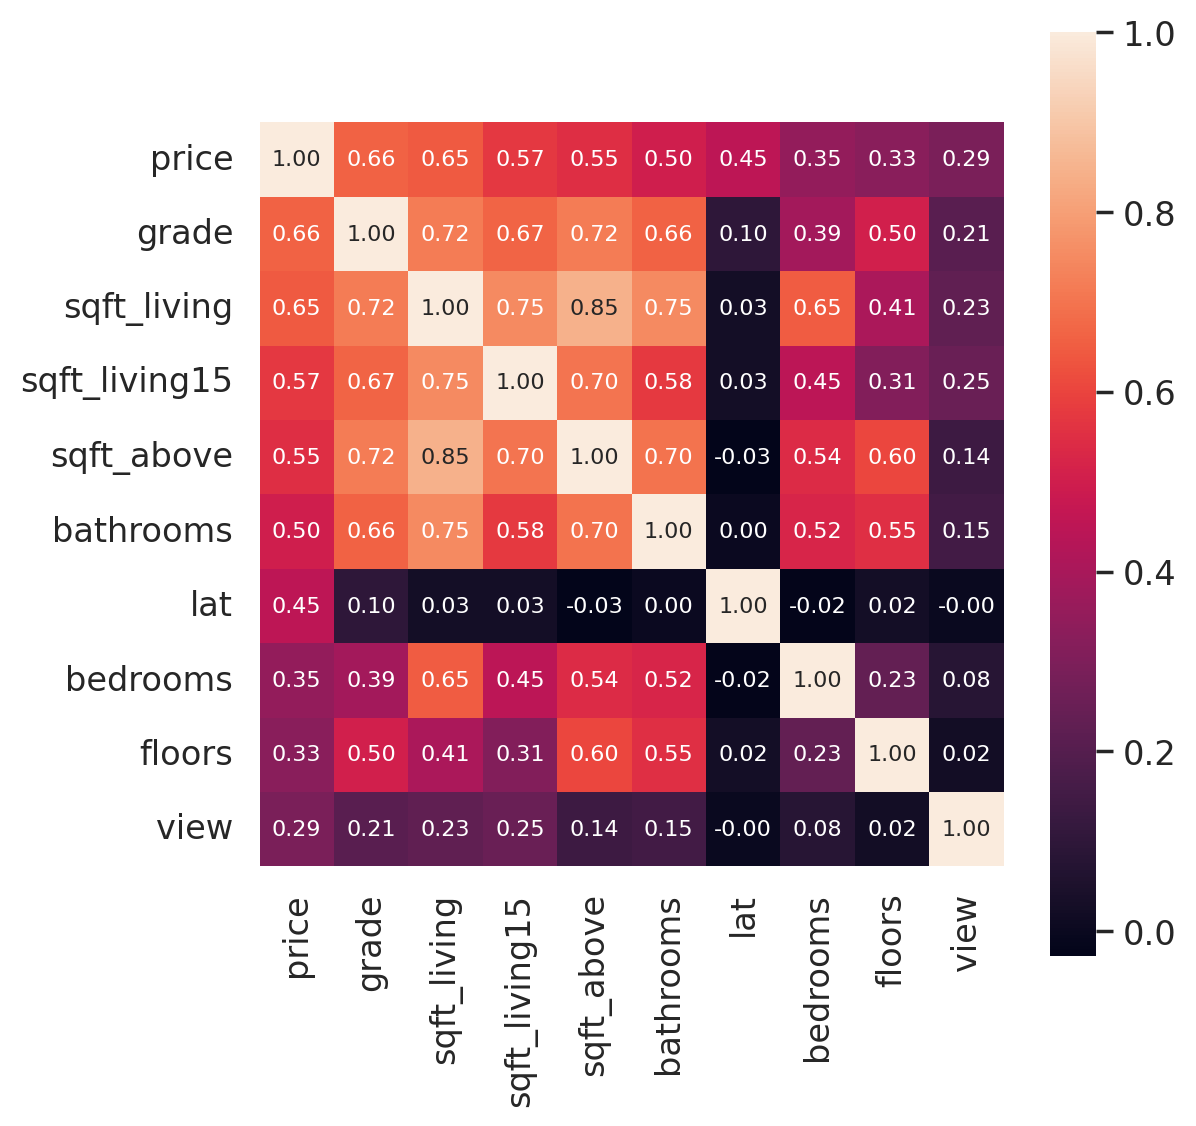

In [138]:
# correlation이 높은 상위 10개의 heatmap
cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(6,6))
sns.set(font_scale=1.1)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

# lat이 price와 상관성이 높음

In [139]:
#train data 전처리 

#date정리 (정수형)
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

#train data에서 price삭제, y변수에 price넣기
y = train['price']
del train['price']

#id컬럼 삭제
del train['id']

train.head(2)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [140]:
#test data 전처리 

#date정리 (정수형)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#id컬럼 삭제
del test['id']

test.tail(2)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,201501,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


<Axes: xlabel='price', ylabel='Density'>

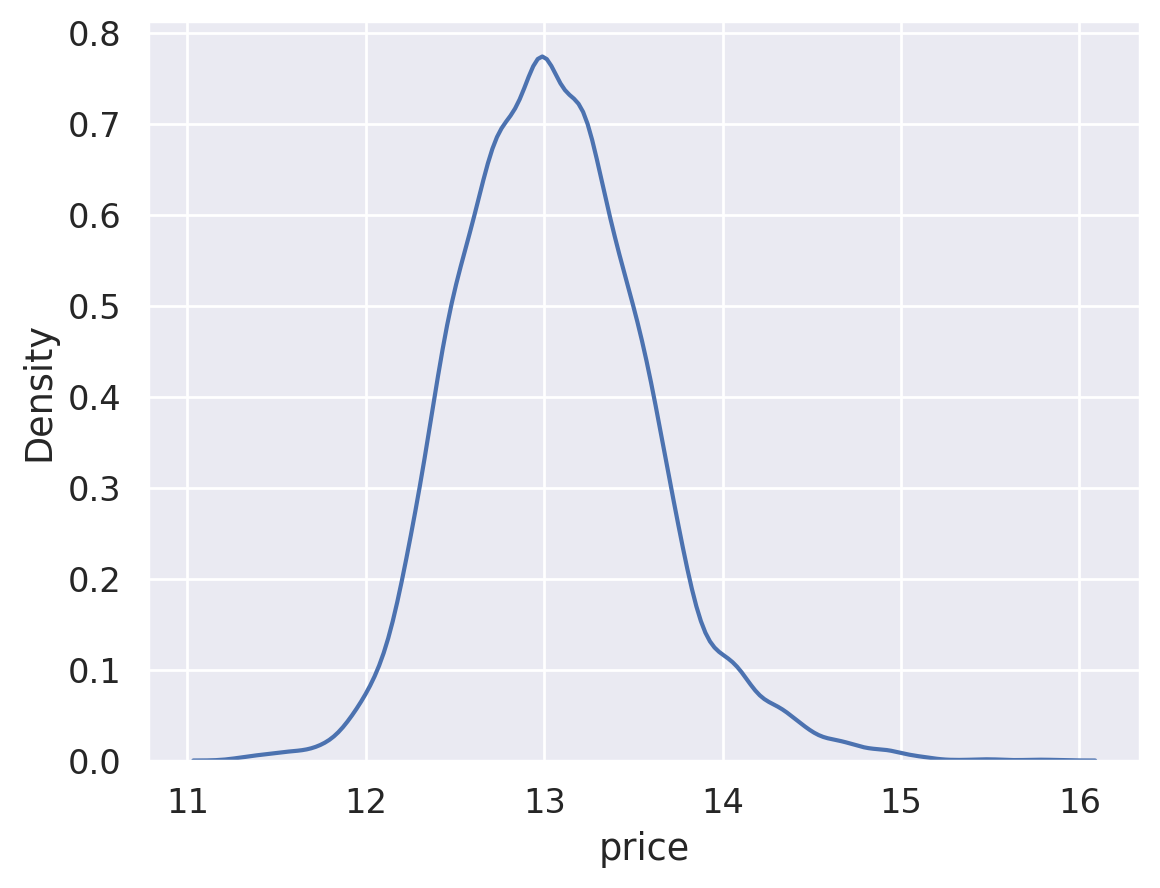

In [141]:
#y정규화
"""
y는 np.log1p() 함수를 통해 로그 변환을 해주고, 
나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌림
"""

y = np.log1p(y)
sns.kdeplot(y)

In [128]:
#skew_columns정규화
skew_columns = ['bedrooms','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [142]:
#전체 데이터 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

모델구축

In [143]:
#f랜덤시드값 설정
random_state=2020 

#모델 선언
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]



def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

하이퍼파라미터 실험

In [144]:
#모델선언
model = LGBMRegressor(random_state=random_state)


#모델학습 -> 파라미터 조합 실험 -> 테스트 점수 확인
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE(Root Mean Squared Log Error)값 계산 후 정렬 
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results


In [145]:
#그리드 탐색

#다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [1, 10, 100, 1000,5000],
}

model = LGBMRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) 
results

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,max_depth,n_estimators,score,RMSLE
7,10,200,-0.026188,0.161828
12,100,200,-0.026245,0.162003
22,5000,200,-0.026245,0.162003
17,1000,200,-0.026245,0.162003
8,10,500,-0.026245,0.162004
18,1000,500,-0.026340,0.162295
13,100,500,-0.026340,0.162295
23,5000,500,-0.026340,0.162295
9,10,1000,-0.026739,0.163521
19,1000,1000,-0.026767,0.163605


탐색한 파라미터로 모델준비/학습 및 예측

In [146]:
max_depth = results["max_depth"].values[0]
n_estimators = results["n_estimators"].values[0]

model = LGBMRegressor(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction1 = np.expm1(prediction)  #로그변환 원복

캐글제출파일 준비

In [147]:
now = datetime.now()

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/gdrive/MyDrive/AIFFEL/230518/data/'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}_date_{}.csv'.format(data_dir, model_name, rmsle, now.date())
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

rmsle = round(results["RMSLE"].values[0], 6)
save_submission(model, train, y, test, 'lgbm', rmsle=rmsle)

/gdrive/MyDrive/AIFFEL/230518/data//submission_lgbm_RMSLE_0.161828_date_2023-05-18.csv saved!
